In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import binom, multinomial, beta, dirichlet

plot_all_lines = False
import warnings
warnings.simplefilter('error', RuntimeWarning)


In [2]:
from scipy.special import binom, loggamma
def logbinom(n, k):
    return loggamma(n+1) - loggamma(k+1) - loggamma(n-k+1)

def logbinom_lnnk(n,k):
    logbinom = k*np.log(n/k - 0.5) + k -0.5*np.log(2*np.pi*k)
    return logbinom
    
def f_b(k, n, p, thresh=100):
    # k is an integer, n is an array
    logf1 = logbinom(n, k)


    logf2 = k*np.log(p)
    logf3 = (n-k)*np.log(1-p)
    logf_b = logf1+logf2+logf3
    return logf_b


def L(Ns, rj, rjp, N_M, Ntot, high_acc=False):
    L = 0
    if high_acc:
        N_Mks = np.linspace(0,N_M,1000)
    else:
        Ns = Ns.astype(int)
        N_Mks = np.arange(N_M+1)
    for k in range(len(N_Mks)):
        L1 = np.zeros(len(Ns))-np.inf
        L2 = np.zeros(len(Ns))-np.inf
        inds = ((Ns >= k) & (Ntot-Ns >= N_M-k))
        L1[inds] = f_b(k, Ns[inds], rj)
        L2[inds] = f_b(N_M-k, Ntot-Ns[inds], 1-rjp)
        L += np.exp(L1+L2)
    return L

In [3]:
Z1 = []
Z2 = []

# Total sample size
N = 193
# True merger fraction
f_M = 0.4

for _ in range(10000):
    # Realization of sample, where index 0 is isolated, 1 is a merger.
    #true_gals = binom.rvs(1, f_M, size=N)
    true_gals = np.random.choice([0,1], size=N, p=[1-f_M, f_M])
    f_M_sample = true_gals.sum()/N
    # Number of classifiers
    n = 14
    r_Ms = np.random.uniform(low=0.5, high=0.8, size=n)
    r_Is = np.random.uniform(low=0.6, high=0.9, size=n)

    # Matrix of classifier answers
    m = np.zeros((n, N), dtype='int')
    for i in range(n):
        for j in range(N):
            if true_gals[j] == 0:
                m[i,j] = np.random.choice([0,1], p=[r_Is[i], 1-r_Is[i]])
            elif true_gals[j] == 1:
                m[i,j] = np.random.choice([0,1], p=[1-r_Ms[i], r_Ms[i]])
    N_M = m.sum(axis=1)
    Ns = np.linspace(1, N, 1000)
    lnLi = L(Ns, r_Ms[i], r_Is[i], N_M[i], N)*0
    for i in range(n):
        lnLi += np.log(L(Ns, r_Ms[i], r_Is[i], N_M[i], N))
    P = np.exp(lnLi - lnLi.max())
    mu = sum(Ns*P)/sum(P)
    var = sum((Ns-mu)**2*P)/sum(P)
    Z1.append((true_gals.sum()-mu)/var**0.5)
               
    mu = N_M.mean()
    sd = np.sqrt(f_M*(1-f_M))*N_M.std()/len(N_M)**0.5
    Z2.append((true_gals.sum()-mu)/sd)

Text(0.5, 0, '$|\\hat N_M-N_M|/\\sigma_{N_M}$')

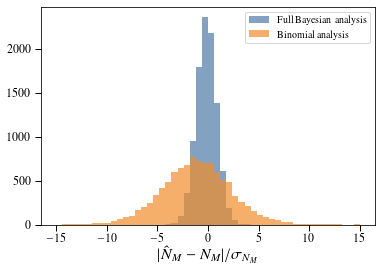

In [8]:
bins = np.linspace(-15,15,51)
plt.hist(Z1, bins=bins, alpha=0.7, label='Full Bayesian analysis')
plt.hist(Z2, bins=bins, alpha=0.7, label='Binomial analysis')
plt.legend(loc='best')
plt.xlabel(r'$|\hat N_M-N_M|/\sigma_{N_M}$')

In [ ]:
plt.hexbin(Z1, Z2, gridsize=40)
plt.xlim([-3.5, 3.5])
plt.ylim([-14.5, 14.5])
plt.colorbar(label=r'$N$')
plt.xlabel(r'$Z$ (full Bayesian)')
plt.ylabel(r'$Z$ (binomial analysis')

Text(0, 0.5, '$Z$ (binomial analysis')